<a href="https://colab.research.google.com/github/irulf/DA-014-Online-Buyer-Seller-Density/blob/main/N_th_transaction_conversion_and_GMV_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sqlalchemy
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine('postgresql+psycopg2://dairul.fuhron@gudangada.com:NmgNkFA53wepusP9@bi-playground.c6l2qlyxjdnr.ap-southeast-1.rds.amazonaws.com:5432/bi-playground')
query = """
WITH temp AS(
SELECT      t.buyer_store_id
            , o.id order_id
            , o.created_at order_created_at
            , ou.product_unit_id
            , ou.final_delivered_quantity
            , (ou.final_delivered_quantity*unit_price) gmv
            , DENSE_RANK() OVER(PARTITION BY t.buyer_store_id ORDER BY o.created_at) order_rank
            , of.status
            , CASE
                WHEN acquisition_channel = 'NON_REFERRED' AND bs.store_name LIKE '%.' THEN 'ONLINE_SALES_RECRUIT'
                WHEN acquisition_channel = 'NON_REFERRED' AND bs.store_name NOT LIKE '%.' THEN 'ONLINE'
                ELSE 'OFFLINE'
              END acquisition_channel
            , bs.classification_type
FROM        "remote-gada-marketplace"."order" o
LEFT JOIN   "remote-gada-marketplace".transaction t ON o.transaction_id = t.id
LEFT JOIN   "remote-gada-marketplace".store bs ON t.buyer_store_id = bs.id
LEFT JOIN   "remote-gada-marketplace".order_unit ou ON o.id = ou.order_id
LEFT JOIN   "remote-gada-marketplace".order_fulfilment of ON o.id = of.order_id
WHERE       o.deleted IS NULL
            AND t.deleted IS NULL
            AND DATE(bs.created_at) > '2020-12-16'
)

SELECT      acquisition_channel
            , classification_type
            , order_rank
            , buyer_store_id
            , order_id
            , SUM(gmv) gmv
            , COUNT(DISTINCT product_unit_id) count_sku
            , SUM(final_delivered_quantity) quantity
FROM        temp
WHERE       acquisition_channel <> 'ONLINE_SALES_RECRUIT'
            AND status = 'COMPLETED'
GROUP BY    1,2,3,4,5
"""
df = pd.read_sql_query(query, engine)
print(df)

OperationalError: ignored

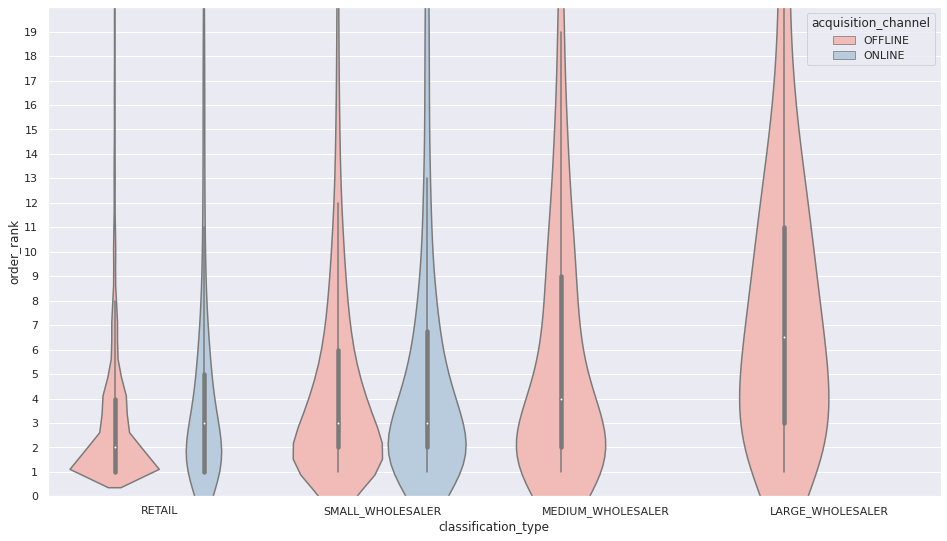

In [3]:
# libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(16,9)})
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
# Grouped violinplot
sns.violinplot(x="classification_type", y="order_rank", hue="acquisition_channel", data=df, palette="Pastel1", order=[ "RETAIL", "SMALL_WHOLESALER", "MEDIUM_WHOLESALER","LARGE_WHOLESALER"])
plt.yticks(np.arange(0, 20, 1))
plt.ylim(0,20)
plt.show()

In [ ]:
# Set the figure size
plt.figure(figsize=(16, 9))
plt.ylim(0,10000)

# Calculate aggregations
df_agg = df.groupby(['acquisition_channel','classification_type'], as_index=False).nunique()[['acquisition_channel','classification_type','buyer_store_id']]
print(df_agg)

# Create labels
label = ()

# grouped barplot
g=sns.barplot(x="classification_type", y="buyer_store_id", hue="acquisition_channel", data=df_agg, ci=None, order=[ "RETAIL", "SMALL_WHOLESALER", "MEDIUM_WHOLESALER","LARGE_WHOLESALER"]);
ax=g
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')

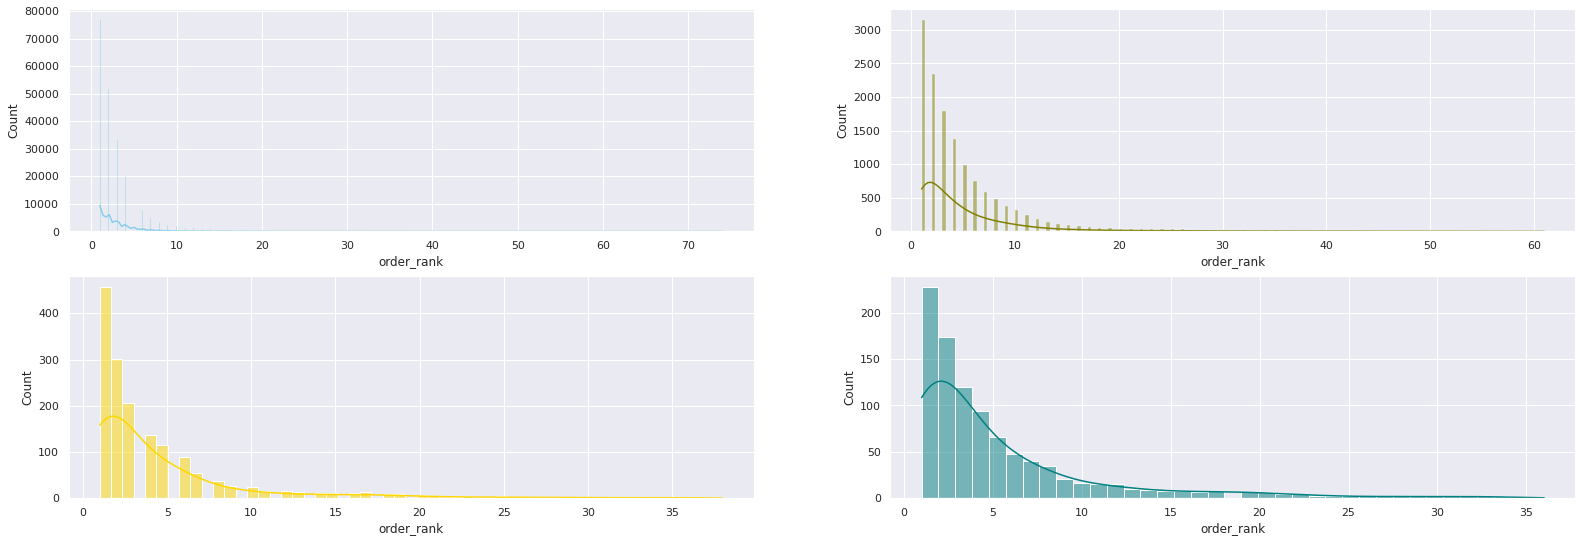

In [7]:
# Distribution Plot

fig, axs = plt.subplots(2, 2, figsize=(27, 9))

sns.histplot(data=df[(df.acquisition_channel == "OFFLINE") & (df.classification_type == "RETAIL")], x="order_rank", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df[(df.acquisition_channel == "OFFLINE") & (df.classification_type == "SMALL_WHOLESALER")], x="order_rank", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df[(df.acquisition_channel == "ONLINE") & (df.classification_type == "RETAIL")], x="order_rank", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df[(df.acquisition_channel == "ONLINE") & (df.classification_type == "SMALL_WHOLESALER")], x="order_rank", kde=True, color="teal", ax=axs[1, 1])

Text(0.5, 1.0, 'OFFLINE - SMALL_WHOLESALER')

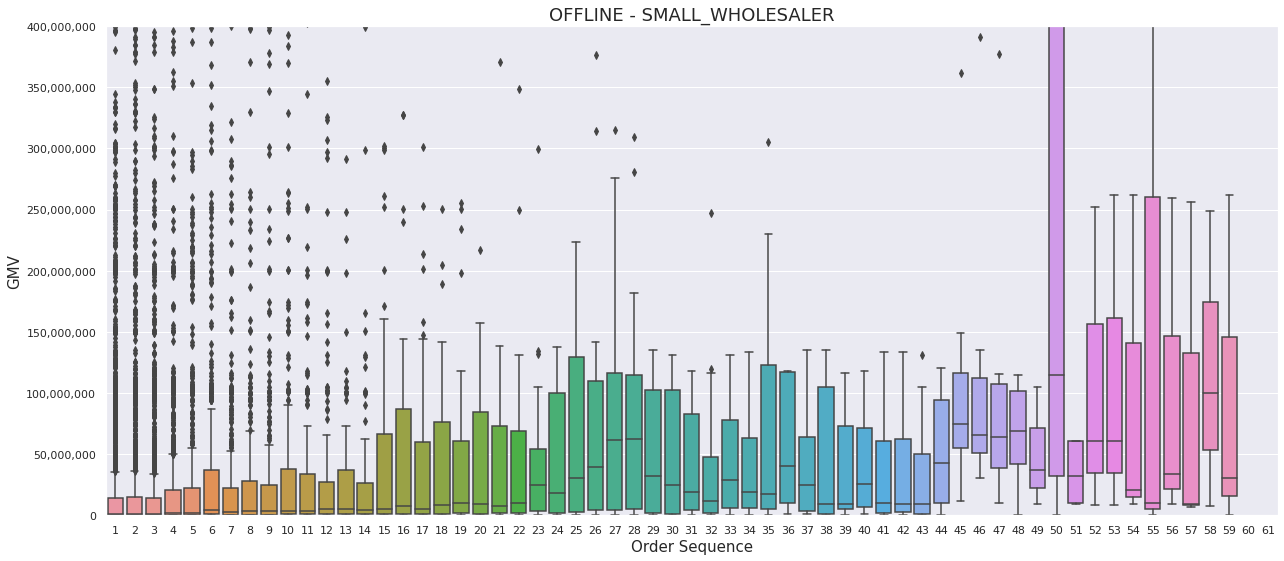

In [82]:
import matplotlib
sns.set(rc={'figure.figsize':(21,9)})

ax = sns.boxplot(x='order_rank', y='gmv', data=df[(df.acquisition_channel == "OFFLINE") & (df.classification_type == "SMALL_WHOLESALER")])

plt.ylim(0,400000000)

plt.ticklabel_format(style='plain', axis='y')

ax.get_yaxis().set_major_formatter(
matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.xlabel('Order Sequence', size=15)
plt.ylabel('GMV', size=15)
plt.title('OFFLINE - SMALL_WHOLESALER', size=18)
